In [1]:
import cv2 as cv
import sys
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

## Changing Brightness and Contrast

The function `adjust_brightness_contrast` changes the brightness and/or contrast of a color or black and white image with values between [0,1]:

In [21]:
def adjust_brightness_contrast(img, beta=0, alpha=1):
    """
    Adjusts the brightness and/or contrast of a color or black and white image.
    
    Args:
        img (numpy.ndarray): The input image to be adjusted.
        beta (float): The brightness adjustment factor, should be in the range [-1, 1].
                      Default value is 0, which means no change.
        alpha (float): The contrast adjustment factor, should be in the range [0, 1].
                       Default value is 1, which means no change.
    
    Returns:
        numpy.ndarray: The adjusted image with the same dimensions as the input image.
    """
    
    # Ensure the beta and alpha values are within their respective ranges
    assert (beta >= -1) and (beta <= 1), "Beta should be in the range [-1, 1]"
    assert (alpha >= 0) and (alpha <= 1), "Alpha should be in the range [0, 1]"

    # Create a copy of the original image to avoid modifying it directly
    new_img = img.copy()

    # Loop through each color channel (assuming the image is in RGB format)
    for channel in range(img.shape[2]):
        # Calculate the mean of the current channel
        c_mean = new_img[:, :, channel].mean()
        # Adjust the brightness and contrast for the current channel
        new_img[:, :, channel] = alpha * ((new_img[:, :, channel] + beta) - c_mean) + c_mean

    # Ensure that the adjusted pixel values are within the valid range [0, 1]
    return np.clip(new_img, 0,1)

Text(0.5, 1.0, 'beta = 0.5; k  = 0.5')

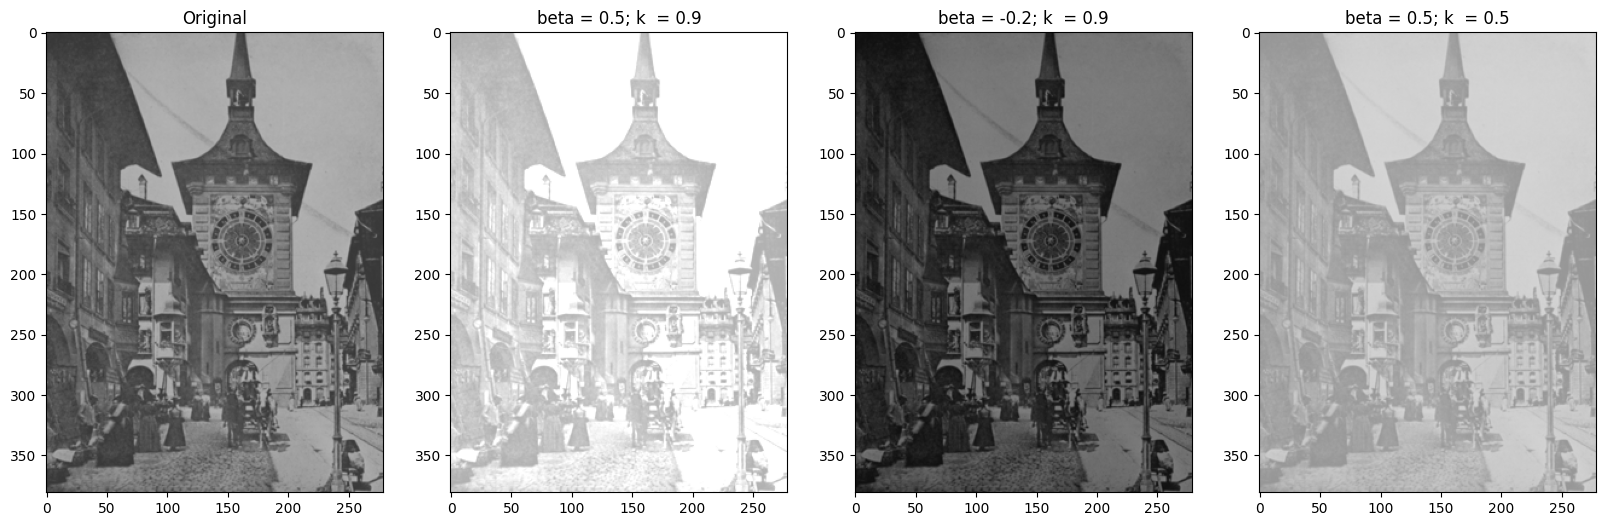

In [22]:
img = cv.imread('img/Poucocontrast.png') / 255
img_t = adjust_brightness_contrast(img, 0.5, 0.9)
img_t2 = adjust_brightness_contrast(img, -0.2, 0.9)
img_t3 = adjust_brightness_contrast(img, 0.5, 0.5)

fig, ax = plt.subplots(ncols=4,figsize=(20,10))

ax[0].imshow(img)
ax[1].imshow(img_t)
ax[2].imshow(img_t2)
ax[3].imshow(img_t3)

ax[0].set_title('Original')
ax[1].set_title('beta = 0.5; k  = 0.9')
ax[2].set_title('beta = -0.2; k  = 0.9')
ax[3].set_title('beta = 0.5; k  = 0.5')

## Histogram

We start by analyzing the brightness. The OpenCV function only accepts images in the range [0, 255], so we need to make a small adjustment to perform the correct comparison:

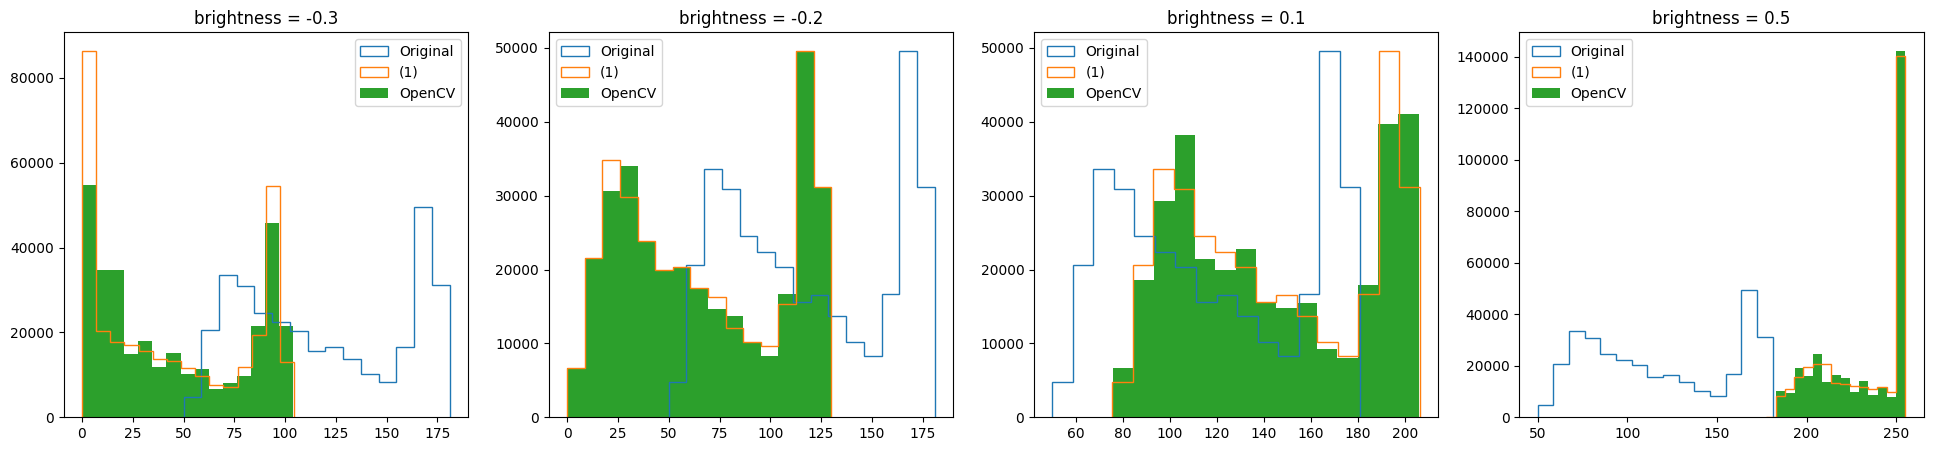

In [25]:
import cv2 as cv
import matplotlib.pyplot as plt

# Read the image
img = cv.imread('img/Poucocontrast.png')

# Define brightness adjustment values and number of bins for histogram
brightness = [-0.3, -0.2, 0.1, 0.5]
bins = 15

fig, ax = plt.subplots(ncols=len(brightness), figsize=(6 * len(brightness), 5))

# Loop through each brightness adjustment value
for count, brightness in enumerate(brightness):

    # Adjust the brightness of the image using the custom function
    img_t = adjust_brightness_contrast(img / 255, brightness)

    # Adjust the brightness of the image using OpenCV
    img_cv = cv.convertScaleAbs(img, beta=brightness * 255)

    # Plot the histogram of the original image
    ax[count].hist(img.flatten(), histtype='step', label='Original', bins=bins)

    # Plot the histogram of the image adjusted by the custom function
    ax[count].hist((img_t * 255).flatten(), histtype='step', label='(1)', bins=bins)

    # Plot the histogram of the image adjusted by OpenCV
    ax[count].hist(img_cv.flatten(), histtype='stepfilled', label='OpenCV', bins=bins)
    
    ax[count].legend()
    ax[count].set_title(f'brightness = {brightness}')

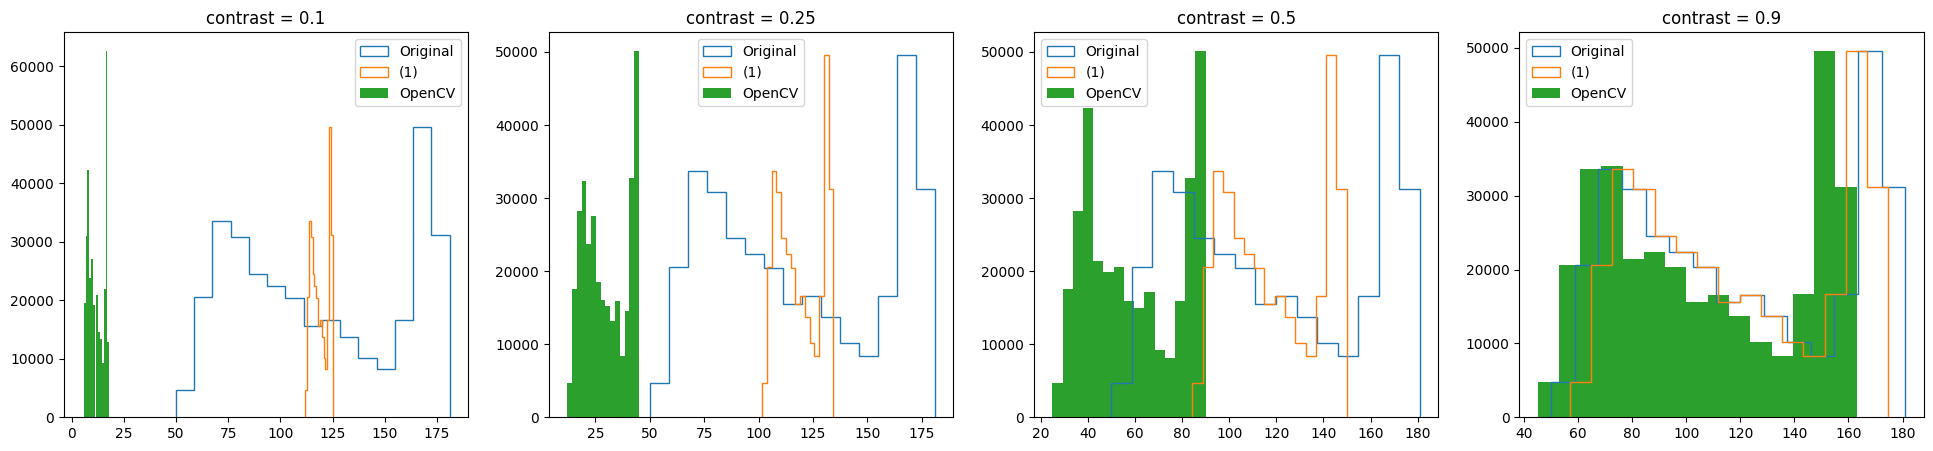

In [27]:
import cv2 as cv
import matplotlib.pyplot as plt

# Read the image
torre = cv.imread('img/PoucoContraste.png')

# Define contrast adjustment values and number of bins for histogram
contrast = [0.1, 0.25, 0.5, 0.9]
bins = 15

# Create subplots for each contrast adjustment
fig, ax = plt.subplots(ncols=len(contrast), figsize=(6 * len(contrast), 5))

# Loop through each contrast adjustment value
for count, contrast in enumerate(contrast):
    # Adjust the contrast of the image using the custom function
    img_t = adjust_brightness_contrast(torre / 255, alpha=contrast)
    # Adjust the contrast of the image using OpenCV
    img_cv = cv.convertScaleAbs(torre, alpha=contrast)

    # Plot the histogram of the original image
    ax[count].hist(torre.flatten(), histtype='step', label='Original', bins=bins)
    # Plot the histogram of the image adjusted by the custom function
    ax[count].hist((img_t * 255).flatten(), histtype='step', label='(1)', bins=bins)
    # Plot the histogram of the image adjusted by OpenCV
    ax[count].hist(img_cv.flatten(), histtype='stepfilled', label='OpenCV', bins=bins)
    
    ax[count].legend()
    ax[count].set_title(f'contrast = {contrast}')


Clearly, the functions do not implement the same methodology. The major divergence in contrast adjustment is due to the fact that OpenCV does not perform the mean adjustment implemented in function (1), as described in the [documentation](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga3460e9c9f37b563ab9dd550c4d8c4e7d:~:text=void%20cv%3A%3A-,convertScaleAbs).

## Image Filters

First, we implement a simple convolution filter

In [28]:
def conv_filter(img, cur_filter):
  """
  Applies a convolution filter to an image.

  Args:
    img (numpy.ndarray): The input image.
    cur_filter (numpy.ndarray): The convolution filter.

  Returns:
    numpy.ndarray: The filtered image.
  """

  filter_rows, filter_cols = cur_filter.shape

  img = np.float16(img)

  pad_height = filter_rows - 1
  pad_width = filter_cols - 1
  padded_img = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

  new_img = np.zeros_like(padded_img)

  for r_num, row in enumerate(range(padded_img.shape[0] - pad_height)):
    for c_num, col in enumerate(range(padded_img.shape[1] - pad_width)):

      cur_matrix = padded_img[row:row + filter_rows, col:col + filter_cols]
      cur_pixel = np.sum(cur_matrix * cur_filter)

      new_img[r_num, c_num] = cur_pixel

  if (pad_height != 0) and (pad_width != 0):
    new_img = new_img[:-pad_height, :-pad_width]

  return np.clip(new_img, 0, 255)

To test it, we can apply various convolution filters: constant, horizontal and vertical derivatives, Sobel horizontal and vertical, and Gaussian.

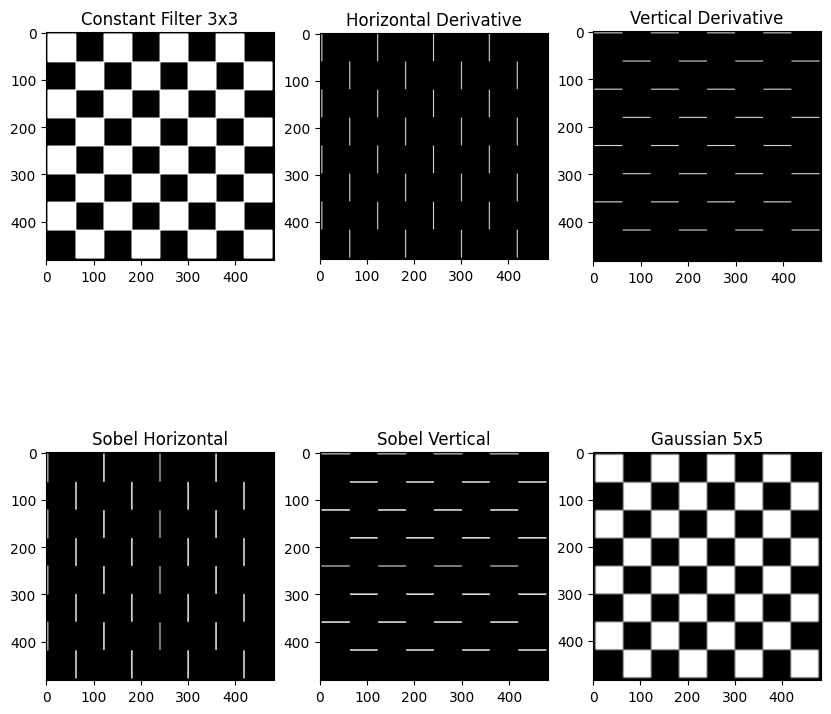

In [32]:
xadrez = cv.imread('img/Chess_Board.png')[:, :, 0]

# Constant 3x3 filter
const_3x3 = np.ones((3, 3)) / 5
const_3x3 /= sum(const_3x3)

# Horizontal derivative 1x3 and vertical derivative 3x1
derivada_hoz = np.array([-1, 0, 1]).reshape(1, 3)
derivada_vert = np.array([-1, 0, 1]).reshape(3, 1)

# Sobel horizontal and vertical filters 3x3
horizontal_sorbel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
vertical_sorbel = horizontal_sorbel.T

# Gaussian filter with zero mean and variance of 2 pixels, truncated in a 5x5 matrix
def build_gaussian_kernel(size, sigma=1.0, muu=0):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]

    dst = np.sqrt(x**2 + y**2)
    normal = 1 / (2.0 * np.pi * sigma**2)

    gauss = np.exp(-((dst - muu)**2 / (2.0 * sigma**2))) * normal

    return gauss / gauss.sum()  # normalize

gaussian_kernel_5x5 = build_gaussian_kernel(5, sigma=2)

# Applying the filters
const_filter = conv_filter(xadrez, const_3x3)

derivada_hoz_filter = conv_filter(xadrez, derivada_hoz)
derivada_vert_filter = conv_filter(xadrez, derivada_vert)

horizontal_sorbel_filter = conv_filter(xadrez, horizontal_sorbel)
vertical_sorbel_filter = conv_filter(xadrez, vertical_sorbel)

gaussian_filter = conv_filter(xadrez, gaussian_kernel_5x5)

# Display the filtered images
fig, ax = plt.subplots(2, 3, figsize=(10, 10))

ax[0, 0].imshow(const_filter, cmap='grey')
ax[0, 1].imshow(derivada_hoz_filter, cmap='grey')
ax[0, 2].imshow(derivada_vert_filter, cmap='grey')

ax[1, 0].imshow(horizontal_sorbel_filter, cmap='grey')
ax[1, 1].imshow(vertical_sorbel_filter, cmap='grey')
ax[1, 2].imshow(gaussian_filter, cmap='grey')

# Set titles for the subplots
ax[0, 0].set_title('Constant Filter 3x3')
ax[0, 1].set_title('Horizontal Derivative')
ax[0, 2].set_title('Vertical Derivative')

ax[1, 0].set_title('Sobel Horizontal')
ax[1, 1].set_title('Sobel Vertical')
ax[1, 2].set_title('Gaussian 5x5')

plt.show()


### Dimensionality Reduction

We want to reduce both dimensions by half.  Without smoothing, we can simply crop rows and columns in steps of 2. With smoothing, we can simply apply the GaussianBlur function from OpenCV before cropping the rows and columns:

Text(0.5, 1.0, 'Zytglogge (Suavizada) (191, 140)')

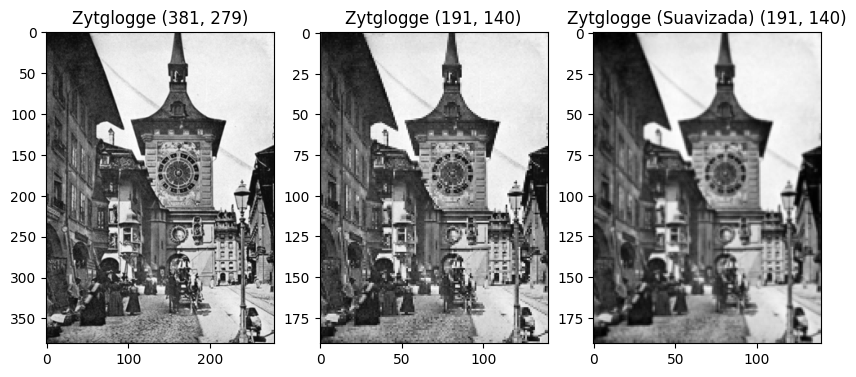

In [36]:
torre = torre[:,:,0]

def reduz_img(img):
    return img[::2,::2]

torre_metade = reduz_img(torre)
torre_suave = reduz_img(cv.GaussianBlur(torre, (5, 5), 0))

fig, ax = plt.subplots(ncols=3, figsize=(10,10))

ax[0].imshow(torre, cmap='grey')
ax[1].imshow(torre_metade, cmap='grey')
ax[2].imshow(torre_suave, cmap='grey')

ax[0].set_title(f'Zytglogge {torre.shape}')
ax[1].set_title(f'Zytglogge {torre_metade.shape}')
ax[2].set_title(f'Zytglogge (Suavizada) {torre_suave.shape}')

## Kuwahara Filter

We start by adding Gaussian noise to the image:

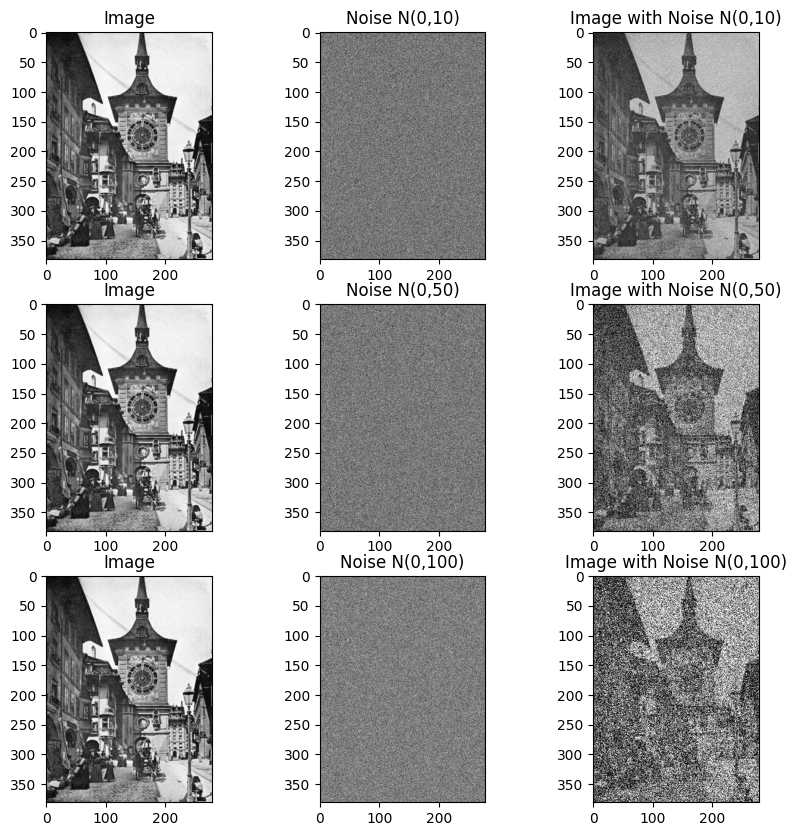

In [37]:
def add_gauss_noise(img, mean=0, sigma=50):
    noise =  np.random.normal(mean, sigma, img.shape)
    img_noise =  img +noise
    return np.clip(img_noise, 0, 255).astype(np.uint8), noise
     
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10))

for row, sigma in enumerate([10, 50, 100]):

    img_with_noise, ruido = add_gauss_noise(torre, sigma=sigma)

    ax[row, 0].imshow(torre, cmap='grey')
    ax[row, 1].imshow(ruido, cmap='grey')
    ax[row, 2].imshow(img_with_noise, cmap='grey')

    ax[row, 0].set_title(f'Image')
    ax[row, 1].set_title(f'Noise N(0,{sigma})')
    ax[row, 2].set_title(f'Image with Noise N(0,{sigma})')

Next, we implement Kuwahara filter:

In [13]:
def kuwahara_filter(image, ksize=5):
    
    pad_size = ksize // 2
    padded_img = cv.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv.BORDER_REFLECT)
    
    rows, cols = image.shape[:2]
    
    output = np.zeros_like(image)
    
    for y in range(rows):
        for x in range(cols):
            
            region1 = padded_img[y:y + ksize, x:x + ksize]
            region2 = padded_img[y:y + ksize, x:x + ksize + pad_size * 2]
            region3 = padded_img[y:y + ksize + pad_size * 2, x:x + ksize]
            region4 = padded_img[y:y + ksize + pad_size * 2, x:x + ksize + pad_size * 2]

            var1 = np.var(region1)
            var2 = np.var(region2)
            var3 = np.var(region3)
            var4 = np.var(region4)
            
            mean1 = np.mean(region1)
            mean2 = np.mean(region2)
            mean3 = np.mean(region3)
            mean4 = np.mean(region4)

            min_var_index = np.argmin([var1, var2, var3, var4])
            means = [mean1, mean2, mean3, mean4]
            output[y, x] = means[min_var_index]

    return output

Text(0.5, 1.0, 'Kuwahara')

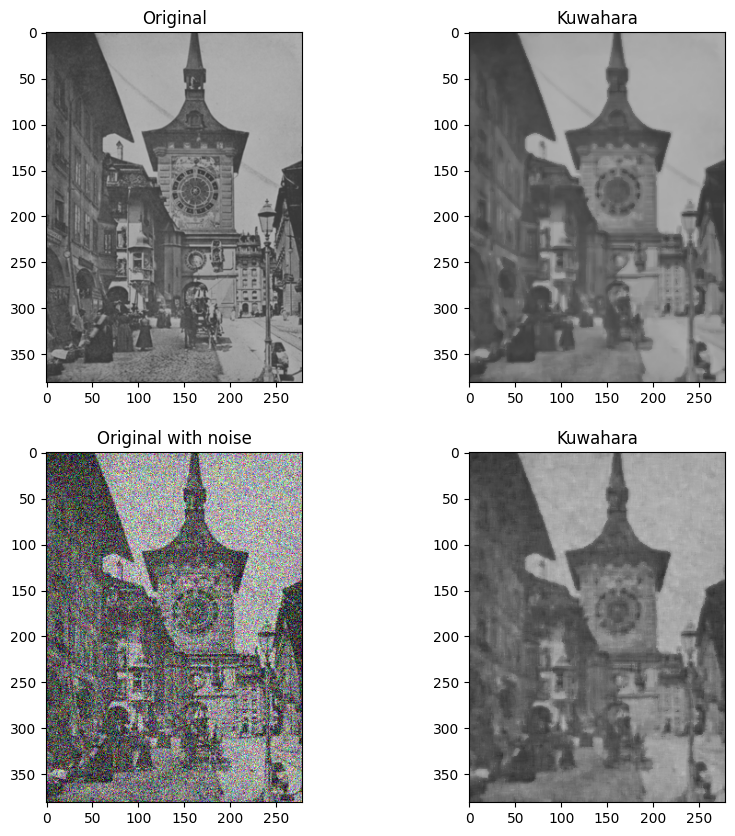

In [38]:
img_without_noise = cv.imread('img/PoucoContraste.png') 

img_with_noise, _ = add_gauss_noise(img_without_noise, sigma=50)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))

ax[0, 0].imshow(img_without_noise, cmap='grey')
ax[0, 1].imshow(kuwahara_filter(img_without_noise,5), cmap='grey')
ax[0, 0].set_title(f'Original')
ax[0, 1].set_title(f'Kuwahara')

ax[1, 0].imshow(img_with_noise, cmap='grey')
ax[1, 1].imshow(kuwahara_filter(img_with_noise,5), cmap='grey')
ax[1, 0].set_title(f'Original with noise')
ax[1, 1].set_title(f'Kuwahara')